# Sinusoidal data with spatial relationships

In [87]:
%load_ext autoreload
%autoreload
import torch
from timegan import *
from utils import *

trainset = TimeGANDatasetSinus(num=300, seq_len=100, features=3)
testset = TimeGANDatasetSinus(num=300, seq_len=100, features=3)
print(len(trainset))
print(trainset[0][0].size())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
30
torch.Size([100, 3])


In [2]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="timegan",
    tags=["rnn"],
    description="",
    source_files=["timegan.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "n_epochs": 10,
    "l_rate": 0.0001,
    "batch_size": 32,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params




model = TimeGAN(feature_dim=params["feature_dim"],
                hidden_dim=params["hidden_dim"],
                num_layers=params["num_layers"],
                padding_value=0.,
                Z_dim=params["Z_dim"],
                max_seq_len=params["max_seq_len"],
                batch_size=params["batch_size"],
                device=torch.device(params["device"]))

timegan_trainer(model,
                trainset,
                batch_size=params["batch_size"],
                device=torch.device(params["device"]),
                learning_rate=params["l_rate"],
                n_epochs=params["n_epochs"],
                max_seq_len=params["max_seq_len"],
                dis_thresh=params["dis_thresh"],
                neptune_logger=run,
                )
# Generate random synthetic data
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0), 100)

r = np.array([data[0].numpy() for data in testset])
f_pca = visualization(r, gen_z, 'pca')
run["PCA"].upload(f_pca)
plt.close(f_pca)
f_tsne = visualization(r, gen_z, 'tsne')
run["tsne"].upload(f_tsne)
plt.close(f_tsne)

run["mode_collapse"] = modeCollapseEvaluator(r, gen_z)

run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-11


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Embedding Network Training


Epoch: 9, Loss: 1.2038: 100%|██████████| 10/10 [00:00<00:00, 11.37it/s]



Start Training with Supervised Loss Only


Epoch: 9, Loss: 0.2035: 100%|██████████| 10/10 [00:00<00:00, 16.66it/s]



Start Joint Training


Epoch: 9, E: 3.2824, G: 10.9513, D: 2.1453: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]

Training Complete and Model Saved
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 39 operations to synchronize with Neptune. Do not kill this process.


All 39 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-11


In [3]:
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0),
                          100)


Generating Data...Done


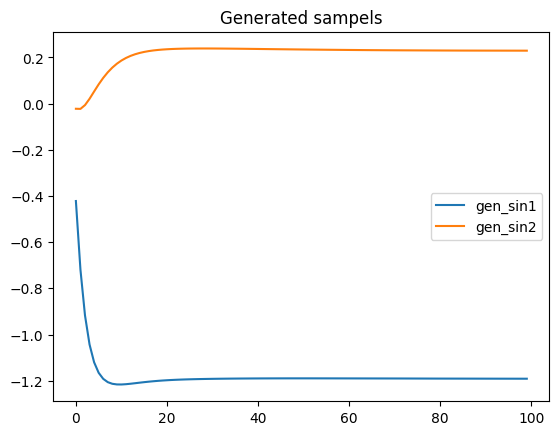

In [4]:
sample = 90
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
#plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

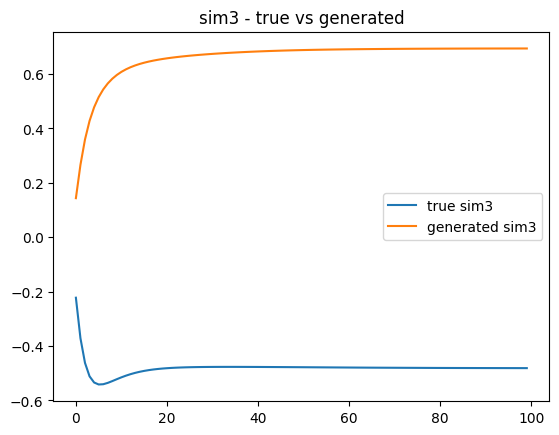

In [5]:
sample = 90
real_combo = (gen_z[sample][:,0] + gen_z[sample][:,1])/2
gen_combo = gen_z[sample][:,2]
plt.plot(real_combo, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

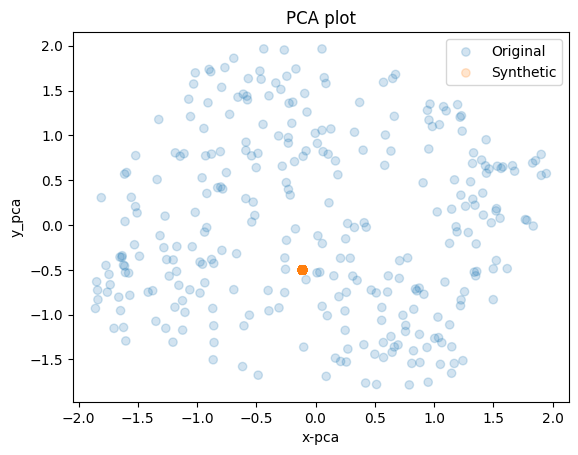

In [6]:
r = np.array([data[0].numpy() for data in testset])
visualization(r, gen_z, 'pca')

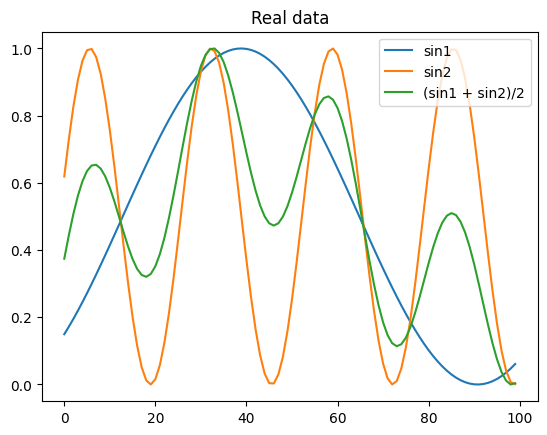

In [6]:
sample = trainset.__getitem__(2)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()

/Users/kohmann/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


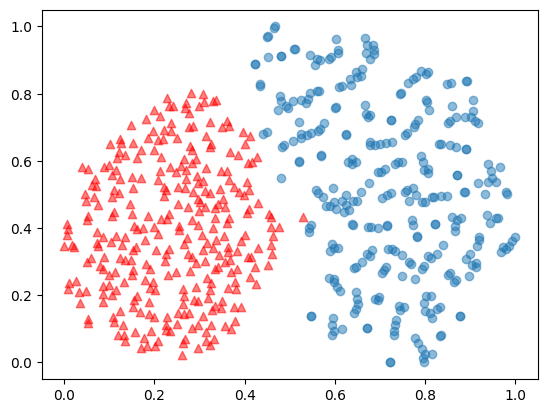

In [8]:
# %matplotlib inline
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

SIZE = len(testset)
train_r = np.array([data[0].numpy() for data in trainset])
r = np.array([data[0].numpy() for data in testset])
X = np.concatenate([gen_z, r], axis=0).reshape(2 * SIZE, -1)
X_embed = TSNE(n_components=2).fit_transform(X)
X_embed = MinMaxScaler().fit_transform(X_embed)

plt.scatter(X_embed[:len(testset), 0], X_embed[:len(testset), 1], c='r', marker='^', alpha=0.5)
plt.scatter(X_embed[len(testset):, 0], X_embed[len(testset):, 1], alpha=0.5)
# plt.show()
plt.show()

# Sinusoidal data with temporal and spatial relationship

200
torch.Size([100, 3])


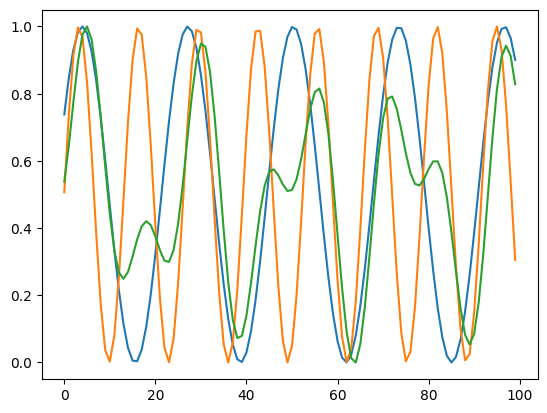

In [1]:
from timegan import *
trainset = TimeGANDatasetSinus(num=200, seq_len=100, features=3, temporal=True)
testset = TimeGANDatasetSinus(num=300, seq_len=100, features=3, temporal=True)


print(len(trainset))
print(trainset[0][0].size())
plt.plot(trainset.__getitem__(0)[0][:,:])

In [2]:
device = "cpu"
feature_dim = trainset[0][0].size(1)
model = TimeGAN(feature_dim=feature_dim,
                hidden_dim=20,
                num_layers=2,
                padding_value=0.,
                Z_dim=100,
                max_seq_len=trainset[0][0].size(0),
                batch_size=64,
                device=torch.device(device))

timegan_trainer(model,
                trainset,
                batch_size=64,
                device=torch.device(device),
                learning_rate=0.0005,
                n_epochs=200,
                max_seq_len=trainset[0][0].size(0),
                dis_thresh=0.15
                )


Start Embedding Network Training


Epoch: 199, Loss: 0.0077: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



Start Training with Supervised Loss Only


Epoch: 199, Loss: 0.0084: 100%|██████████| 200/200 [01:02<00:00,  3.18it/s]



Start Joint Training


Epoch: 199, E: 0.1823, G: 4.0594, D: 1.4919: 100%|██████████| 200/200 [12:21<00:00,  3.71s/it]

Training Complete and Model Saved


In [3]:
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0),
                          100)


Generating Data...Done


In [ ]:
sample = 5
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

In [ ]:
r = np.array([data[0].numpy() for data in testset])
visualization(r, gen_z, 'pca')

In [7]:
data = sine_data_generation(1, 100, 3)

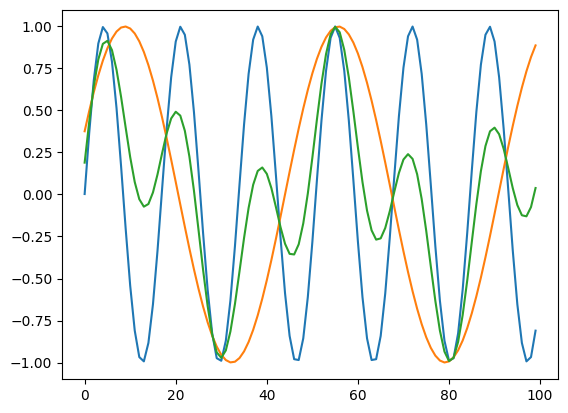

In [8]:
plt.plot(data[0])

In [20]:
from timegan import *

data = trainset.__getitem__(2)[0]
sin1, sin2, sin3 = data[:,0], data[:,1], data[:,2]

sin3_real = create_sin3(sin1, sin2, temporal=True)

In [21]:
sin3_real = minmaxscaler().fit_transform(torch.tensor([sin3_real]))[0]

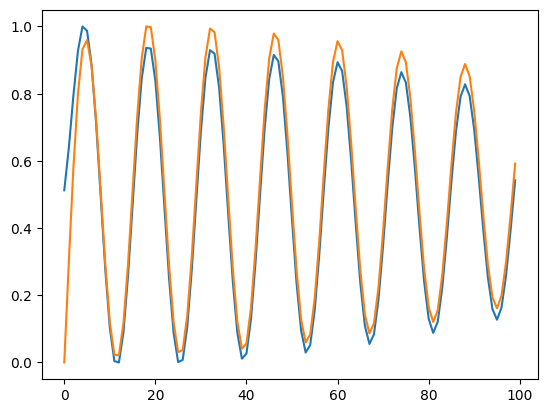

In [25]:
#plt.plot(sin1)
#plt.plot(sin2)
plt.plot(sin3)

plt.plot(sin3_real)


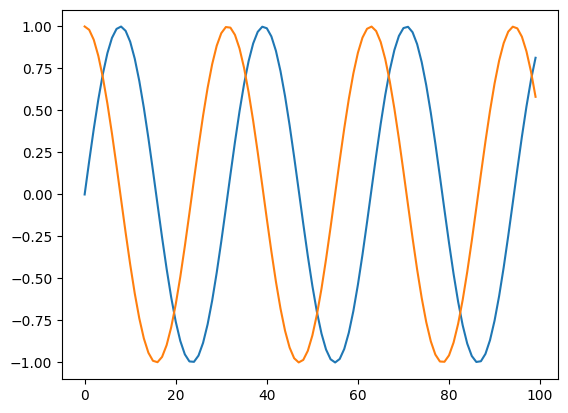

In [36]:
freq = 0.2 #np.random.uniform(0.05, 0.2)  # 0.1
phase = -np.pi/2#np.random.uniform(0, 3)  # 0.1
# Generate sine signal based on the drawn frequency and phase
plt.plot([np.sin(freq * j + 0) for j in range(100)])
plt.plot([np.sin(freq * j + phase) for j in range(100)])

In [8]:
sin1 = [np.sin(freq * j + 0) for j in range(100)]
sin2 = [np.sin(freq * j + phase) for j in range(100)]
temp = [sin1, sin2]
torch.tensor(temp)
temp_scaled = minmaxscaler().fit_transform(torch.tensor(temp))

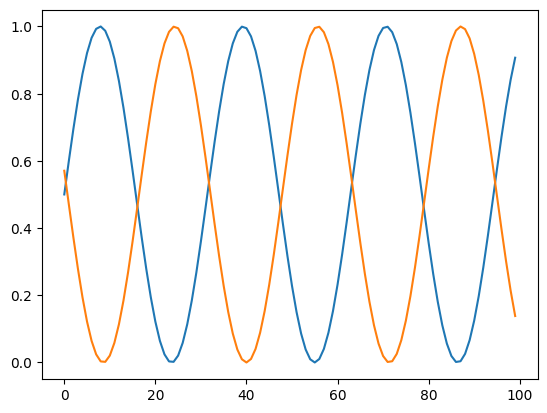

In [10]:
plt.plot(temp_scaled[0])
plt.plot(temp_scaled[1])

In [14]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [19]:
l = [1,2,3]
l.extend([3,2,1])

In [20]:
l

[1, 2, 3, 3, 2, 1]

In [2]:
from timegan import *
data = sine_data_generation(1,100,3)

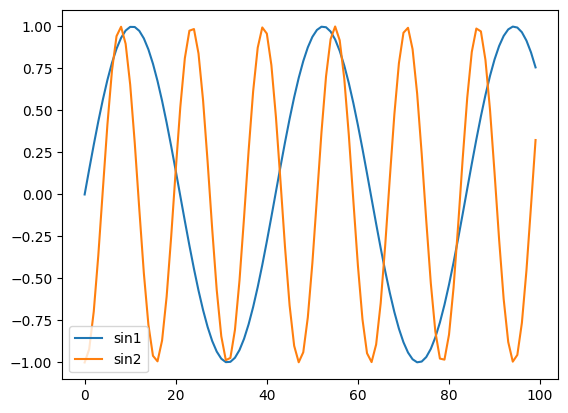

In [36]:
freq1 = 0.15#np.random.uniform(0.05, 0.15)
phase1 = 0#np.random.uniform(-np.pi/2, 0)
sin1 = np.sin(np.arange(100) * freq1 + phase1).tolist()

freq2 = 0.4#np.random.uniform(0.3, 0.4)
phase2 = -np.pi/2#np.random.uniform(0, np.pi / 2)
sin2 = np.sin(np.arange(100) * freq2 + phase2).tolist()
plt.plot(sin1, label="sin1")
plt.plot(sin2, label="sin2")
plt.legend()

In [105]:
# Analysis sample size (for faster computation)
from sklearn.decomposition import PCA

def modeCollapse(ori_data, generated_data):

    anal_sample_no = min([1000, len(ori_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Data preprocessing
    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim = ori_data.shape

    for i in range(anal_sample_no):
        if (i == 0):
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate((prep_data,
                                        np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat,
                                            np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len])))

    # Visualization parameter

    # PCA Analysis
    pca = PCA(n_components=2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)

    real_mean = pca_results.mean(axis=0)
    real_std = pca_results.std(axis=0)
    fake_mean = pca_hat_results.mean(axis=0)
    fake_std = pca_hat_results.std(axis=0)
    print(real_mean, fake_mean)
    print(real_std, fake_std)
    SMD = abs(real_mean - fake_mean) / np.sqrt( (real_std + fake_std)/2 )
    print(SMD)




In [106]:

r = np.array([data[0].numpy() for data in testset])
modeCollapse(r, gen_z)

[3.5613777e-08 3.6557516e-08] [ 0.23968887 -0.37779695]
[1.0515873 0.9593341] [1.0168214e-04 9.9312143e-05]
[0.3305363 0.545464 ]


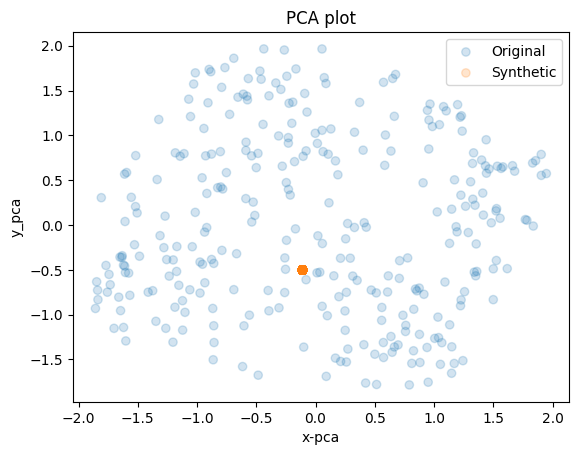

In [14]:
visualization(r, gen_z, "pca")

In [84]:
# Commented out IPython magic to ensure Python compatibility.
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def visualization2(ori_data, generated_data, analysis):
    """Using PCA or tSNE for generated and original data visualization.

    Args:
      - ori_data: original data
      - generated_data: generated synthetic data
      - analysis: tsne or pca
    """
    # Analysis sample size (for faster computation)
    anal_sample_no = min([1000, len(ori_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Data preprocessing
    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim = ori_data.shape

    for i in range(anal_sample_no):
        if (i == 0):
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate((prep_data,
                                        np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat,
                                            np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len])))

    # Visualization parameter
    colors = ["tab:blue" for i in range(anal_sample_no)] + ["tab:orange" for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        # Plotting
        f, ax = plt.subplots(1)
        ax.scatter(pca_results[:, 0], pca_results[:, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original");
        ax.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic");

        ax.legend()
        plt.title('PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y_pca')
        return f


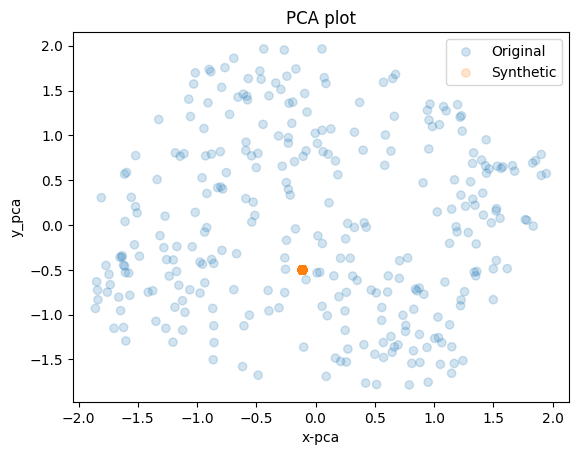

In [86]:

_ = visualization2(r, gen_z, "pca")
#fig.show()

In [68]:
def plot(x, y):
   fig = plt.figure()
   plt.plot(x, y)
   return fig

x = np.linspace(-10, 10, 100)
y = np.sin(x)
f = plot(x, y)
plt.close(f)